In [1]:
import pyro
import torch
from pyro.distributions import Normal, Uniform, constraints
from pyro.infer.autoguide import AutoNormal


from causal_pyro.dynamical.handlers import (
    PointObservation,
    SimulatorEventLoop,
    simulate,
    ODEDynamics
)
from causal_pyro.dynamical.ops import State, Trajectory

In [2]:
class SimpleSIRDynamics(ODEDynamics):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def diff(self, dX: State[torch.Tensor], X: State[torch.Tensor]):
        dX.S = -self.beta * X.S * X.I
        dX.I = self.beta * X.S * X.I - self.gamma * X.I  # noqa
        dX.R = self.gamma * X.I

    def observation(self, X: State[torch.Tensor]):
        S_obs = pyro.sample("S_obs", Normal(X.S, 1))
        I_obs = pyro.sample("I_obs", Normal(X.I, 1))
        R_obs = pyro.sample("R_obs", Normal(X.R, 1))
        usa_expected_cost = torch.relu(S_obs + 2 * I_obs - R_obs)
        pyro.sample("usa_cost", Normal(usa_expected_cost, 1))

# Generate synthetic data from SIR model

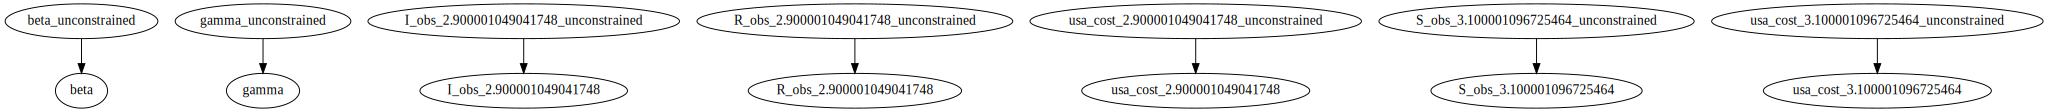

In [66]:
# Initially a population of 100 million people that are susceptible, and no one is infected or recovered
init_state = State(S=torch.tensor(100.), I=torch.tensor(0.), R=torch.tensor(0.))

# We measure the population every month for the next 3 years
time_period = torch.arange(0, 36)

# We 
def model():
    beta = pyro.sample("beta", Uniform(0.0, 1.0))
    gamma = pyro.sample("gamma", Uniform(0.0, 1.0))
    sir = SimpleSIRDynamics(beta, gamma)
    S_obs = torch.tensor(10.0)
    data1 = {"S_obs": S_obs}
    data2 = {"I_obs": torch.tensor(5.0), "R_obs": torch.tensor(5.0)}
    with SimulatorEventLoop():
        with PointObservation(time=3.1, data=data2):
            with PointObservation(time=2.9, data=data1):
                result = simulate(sir, init_state, tspan)

guide = AutoNormal(model)
pyro.render_model(guide)

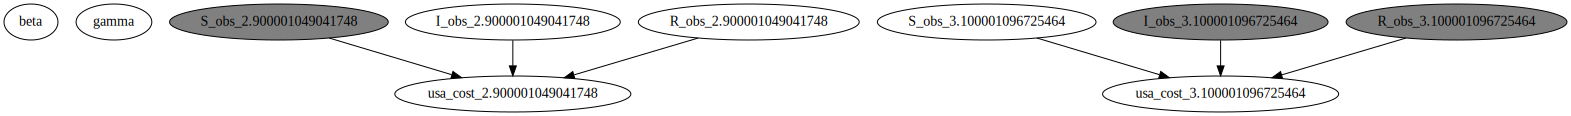

In [67]:
pyro.render_model(model)

In [38]:
# Generate different states for a number of different countries
# Each country conditional on covariates, has same dynamics

# Some countries enact different policies at different times
# pool all information together to estimate dynamics